### Environment

In [34]:
### LLMs
import os

os.environ["USER_AGENT"] = "Mozilla/5.0"
os.environ['COHERE_API_KEY'] = "<your-api-key>"
os.environ['TAVILY_API_KEY'] = "<your-api-key>"

### Indexing

In [35]:
### Indexing

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_cohere import CohereEmbeddings

# Set embeddings
embed = CohereEmbeddings(model="embed-english-v3.0")

# Docs to index
urls = [
    "https://distill.pub/2021/gnn-intro/",
    "https://distill.pub/2021/understanding-gnns/"
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 512, chunk_overlap = 0
)

doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="adaptive-rag",
    embedding=embed
)

# Retriever 
retriever = vectorstore.as_retriever()

### LLM

#### Router

In [36]:
### Router

from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_cohere import ChatCohere

# Data model
class web_search(BaseModel):
    """
    The internet. Use web_search for questions that are related to anything else than agents, prompt engineering, and adversarial attacks.
    """

    query: str = Field(description="The query to use when searching the internet.")

class vectorstore(BaseModel):
    """
    A vectorstore containing documents related to Graph Neural Networks. Use the vectorstore for questions on these topics.
    """

    query: str = Field(description="The query to use when searching the vectorstore.")

# LLM with function call
llm = ChatCohere(model="command-r-plus", temperature=0)
structured_llm_router = llm.bind_tools(
    tools=[web_search, vectorstore]
)

In [37]:
# Few shot prompting
routing_examples = [
    {"question": "What are the main components of a Graph Neural Network?", "decision": "vectorstore"},
    {"question": "Who won the Nobel Prize in Physics in 2023?", "decision": "web_search"},
    {"question": "How do GNNs handle the over-smoothing problem?", "decision": "vectorstore"},
    {"question": "What is the capital of Japan?", "decision": "web_search"},
    {"question": "Can you explain how Graph Attention Networks (GATs) work?", "decision": "vectorstore"},
]

example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{question}"),
        ("ai", "{decision}"),
    ]
)

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=routing_examples,
)

In [38]:
# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
    The vectorstore contains documents related to Graph Neural Networks (GNNs).
    Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        few_shot_prompt,
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

response = question_router.invoke({"question": "Who won the Nobel Prize in Physics in 2023?"})
print(response.response_metadata["tool_calls"])
response = question_router.invoke({"question": "What are the types of Graph Neural Network?"})
print(response.response_metadata["tool_calls"])
response = question_router.invoke({"question": "Hi how are you?"}) # answers directly
print("tool_calls" in response.response_metadata)

[{'id': '5d71b2cabf0b43b5808e1275eb9cfac3', 'function': {'name': 'web_search', 'arguments': '{"query": "Who won the Nobel Prize in Physics in 2023?"}'}, 'type': 'function'}]
[{'id': '78baae66e1ce4663b6cef23c1be1796d', 'function': {'name': 'vectorstore', 'arguments': '{"query": "types of Graph Neural Network"}'}, 'type': 'function'}]
False


#### Retrieval Grader

In [39]:
### Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        ...,
        description="Documents are relevant to the question, 'yes' or 'no'.",
    )

# LLM with function call
llm = ChatCohere(model="command-r-plus", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [40]:
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [41]:
question = "Graph Attention"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
response = retrieval_grader.invoke({"question": question, "document": doc_txt})
print(response)

binary_score='yes'


#### Generate

In [42]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
system = """You are an assistant for question-answering tasks. Answer the question based upon your knowledge. 
Use three sentences maximum and keep the answer concise."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved documents: \n\n {documents} \n\n User question: {question}"),
    ]
)

# LLM
llm = ChatCohere(model="command-r-plus", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents":format_docs(docs), "question": question})
print(generation)

Graph Attention Networks (GATs) use a scalar scoring function to weigh the importance of neighboring nodes, normalizing weights to focus on the most relevant neighbors for a given task. This attention mechanism preserves permutation invariance and forms the basis of GATs and Set Transformers.


#### LLM fallback

In [43]:
### LLM fallback

from langchain_core.output_parsers import StrOutputParser

# Prompt
system = """You are an assistant for question-answering tasks. Answer the question based upon your knowledge. 
Use three sentences maximum and keep the answer concise."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: {question}"),
    ]
)

# LLM
llm = ChatCohere(model="command-r-plus", temperature=0)

# Chain
llm_chain = prompt | llm | StrOutputParser()

# Run
question = "Hi how are you?"
generation = llm_chain.invoke({"question": question})
print(generation)

I don't have feelings as an AI chatbot, but I'm functioning well and ready to assist with any questions or tasks you have for me. How can I help you today?


#### Hallucination Grader

In [44]:
### Hallucination grader

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in 'generation' answer."""

    binary_score: str = Field(
        ...,
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

# LLM with function call
llm = ChatCohere(model="command-r-plus", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [45]:
# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader

In [46]:
response = hallucination_grader.invoke({"documents": docs, "generation": generation})
print(response)

binary_score='no'


#### Answer Grader

In [47]:
### Answer grader

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses the question."""

    binary_score: str = Field(
        ...,
        description="Answer address the question, 'yes' or 'no'."
    )

# LLM with function call
llm = ChatCohere(model="command-r-plus", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

In [48]:
# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
    Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader

In [49]:
response = answer_grader.invoke({"question": question, "generation": generation})
print(response)

binary_score='yes'


#### Question Re-writer

In [50]:
### Question Re-writer

# LLM
llm = ChatCohere(model="command-r-plus", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
    for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [51]:
response = question_rewriter.invoke({"question": "tell me about convolutions in graphs?"})
print(response)

What are convolutions in the context of graph neural networks and how do they work?


#### Web Search Tool

In [52]:
### Web Search
 
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

### Graph

#### Graph State

In [53]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

#### Graph Flow

In [54]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def llm_fallback(state):
    """
    Generate answer using the LLM w/o vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---LLM Fallback---")
    question = state["question"]
    generation = llm_chain.invoke({"question": question})
    return {"question": question, "generation": generation}

def generate(state):
    """
    Generate answer using the vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    if not isinstance(documents, list):
        documents = [documents]
        
    # RAG generation-
    generation = rag_chain.invoke({"documents": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECKING DOCUMENTS RELEVANCY TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """
    Transform the query to produce a better question
    
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

### Edges ###

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTING QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})

    # Fallback to LLM or raise error if no decision
    if "tool_calls" not in source.additional_kwargs:
        print("---ROUTED QUESTION TO LLM---")
        return "llm_fallback"
    if len(source.additional_kwargs["tool_calls"]) == 0:
        raise "Router could not decide source"

    # Choose datasource
    datasource = source.additional_kwargs["tool_calls"][0]["function"]["name"]
    if datasource == "web_search":
        print("---ROUTED QUESTION TO WEB SEARCH---")
        return "web_search"
    elif datasource == "vectorstore":
        print("---ROUTED QUESTION TO RAG---")
        return "vectorstore"
    else:
        print("---ROUTED QUESTION TO LLM---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, WEB SEARCH---")
        return "web_search"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECKING HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

#### Build Graph

In [55]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes 
workflow.add_node('web_search', web_search) # web search
workflow.add_node('retrieve', retrieve) # retrieve
workflow.add_node('grade_documents', grade_documents) # grade documents
workflow.add_node('generate', generate) # rag
workflow.add_node('llm_fallback', llm_fallback) # llm
workflow.add_node('transform_query', transform_query) # re-writes query

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
        "llm_fallback": "llm_fallback",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "web_search": "web_search",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",  # Hallucinations: re-generate
        "not useful": "transform_query",  # Fails to answer question: fall-back to web-search
        "useful": END,
    }
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_edge("llm_fallback", END)

# Compile
app = workflow.compile()


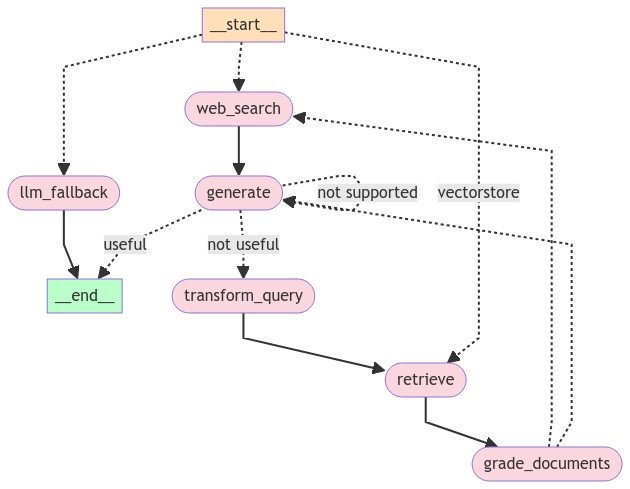

In [56]:
import time
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# Run with rate limit
inputs = {
    "question": "Neet paper leak news?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
    print("\n---\n")
    # Add a delay of 6 seconds between API calls
    time.sleep(6)
    print("\n---\n")

# Final generation
print(value["generation"])

In [ ]:
# Run with rate limit
inputs = {
    "question": "What are the types of differnt graph neural nets?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
    print("\n---\n")
    # Add a delay of 6 seconds between API calls
    time.sleep(6)
    print("\n---\n")

# Final generation
print(value["generation"])

In [ ]:
# Run with rate limit
inputs = {
    "question": "Hello, how are you today?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
    print("\n---\n")
    # Add a delay of 6 seconds between API calls
    time.sleep(6)
    print("\n---\n")

# Final generation
print(value["generation"])